**Ameya Dehade**

In [15]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr 
import numpy as np

iterations = [
    
    # 2 year periods
    ('2022-02-01', '2024-02-01'),
    ('2020-02-01', '2022-02-01'),
    ('2018-02-01', '2020-02-01'),
    ('2016-02-01', '2018-02-01'),
    ('2014-02-01', '2016-02-01'),
    ('2012-02-01', '2014-02-01'),
    ('2010-02-01', '2012-02-01'),
    
    # 3 year periods
    ('2021-02-01', '2024-02-01'),
    ('2018-02-01', '2021-02-01'),
    ('2015-02-01', '2018-02-01'),
    ('2012-02-01', '2015-02-01'),
    ('2010-02-01', '2013-02-01'),
    
    # 4 year periods
    ('2020-02-01', '2024-02-01'),
    ('2016-02-01', '2020-02-01'),
    ('2012-02-01', '2016-02-01'),
    ('2010-02-01', '2014-02-01'),
    
    # 5 year periods
    ('2019-02-01', '2024-02-01'),
    ('2014-02-01', '2019-02-01'),
    ('2010-02-01', '2015-02-01'),
    
    # 6 year periods
    ('2018-02-01', '2024-02-01'),
    ('2012-02-01', '2018-02-01'),
    ('2010-02-01', '2016-02-01'),
    
    # 8 year periods
    ('2016-02-01', '2024-02-01'),
    ('2010-02-01', '2018-02-01'),
    
    # Entire Period
    ('2010-02-01', '2024-02-01')
]

df = pd.read_csv('IBOVDia_03-04-24.csv')
tickers = df['Code'].values
end = len(tickers) - 2
mySymbols = [s + '.SA' for s in tickers[:end]]

# Overall time period
START_DATE = '2010-02-01'
TRUNCATE_DATE = '2011-02-01'
END_DATE = '2024-02-01'

priceTablesByTicker = {}

priceTable = pd.read_csv('priceTable.csv', parse_dates=[0])
priceTable.set_index(priceTable.columns[0], inplace=True)

for ticker in mySymbols:
    currTable = pd.read_csv(ticker + '_price_table.csv', parse_dates=[0])
    currTable.set_index(currTable.columns[0], inplace=True)
    priceTablesByTicker[ticker] = currTable

In [16]:
def benchmark_strategies(priceTable, start_date, end_date):
    rtn = priceTable.loc[start_date:end_date].pct_change()*100
    truncate_date = pd.to_datetime(start_date) + pd.DateOffset(years=1)
    rtn_prev = rtn.shift(periods = 1)
    df_5d_rolling = rtn_prev.rolling(5).sum()
    df_5d_rolling.dropna(inplace=True, how='all')
    
    mom_sig_raw_arr = []
    mom_sig_raw = rtn.shift(22).rolling(231).sum().dropna(how='all')
    mom_sig_mean = mom_sig_raw.mean(axis = 1)
    mom_sig_std = mom_sig_raw.std(axis = 1)
    mom_sig_norm = mom_sig_raw.sub(mom_sig_mean, axis = 0).div(mom_sig_std, axis = 0)
    
    mom_rtn = (mom_sig_norm/(574-1) * rtn).sum(axis=1)
    mom_rtn_mean = mom_rtn.mean() * 252     
    mom_rtn_std = mom_rtn.std() * 252**0.5
    mom_SR = mom_rtn_mean / mom_rtn_std
    
    mr_sig_raw = - df_5d_rolling
    mr_sig_mean = mr_sig_raw.mean(axis = 1)
    mr_sig_std = mr_sig_raw.std(axis = 1)
    mr_sig_norm = mr_sig_raw.sub(mr_sig_mean, axis = 0).div(mr_sig_std, axis = 0)
    mr_sig_raw.head()
    
    mr_rtn = (mr_sig_norm/(574-1) * rtn).truncate(before=truncate_date).sum(axis=1) #starts 2020
    mr_rtn_mean = mr_rtn.mean() * 252
    mr_rtn_std = mr_rtn.std() * (252**0.5)
    mr_SR = mr_rtn_mean / mr_rtn_std
        
    both_rtn = 0.5*mom_rtn + 0.5*mr_rtn  # This is the return of a 50/50 portfolio of both strategies.
    both_rtn_mean = both_rtn.mean() * 252
    both_rtn_std = both_rtn.std() * 252**0.5
    both_SR = both_rtn_mean / both_rtn_std
    
    return mom_rtn.cumsum()/mom_rtn.std()*0.15, mr_rtn.cumsum()/mr_rtn.std()*0.15, both_rtn.cumsum()/both_rtn.std()*0.15, mom_SR, mr_SR, both_SR

In [22]:
def calculate_atr(stock_data, period=14):
    high_low = stock_data['High'] - stock_data['Low']
    high_close = np.abs(stock_data['High'] - stock_data['Close'].shift())
    low_close = np.abs(stock_data['Low'] - stock_data['Close'].shift())
    tr = pd.DataFrame({'high_low': high_low, 'high_close': high_close, 'low_close': low_close}).max(axis=1)
    atr = tr.rolling(window=period).mean()
    return atr

def turtle_atr(stock, atr_period=14, X=2, Y=2):
    # Calculate high, low, avg for original turtle strategy
    stock['high'] = stock['Close'].shift(1).rolling(window=5).max()  # 5 day high
    stock['low'] = stock['Close'].shift(1).rolling(window=5).min()   # 5 day low
    stock['avg'] = stock['Close'].shift(1).rolling(window=5).mean()  # 5 day mean

    # Calculate ATR
    stock['ATR'] = calculate_atr(stock, atr_period)

    #og turtle
    stock['long_entry'] = stock['Close'] > stock['high']
    stock['short_entry'] = stock['Close'] < stock['low']
    stock['long_exit'] = stock['Close'] < stock['avg']
    stock['short_exit'] = stock['Close'] > stock['avg']

    stock['positions_long'] = np.nan
    stock.loc[stock['long_entry'], 'positions_long'] = 1
    stock.loc[stock['long_exit'], 'positions_long'] = 0

    stock['positions_short'] = np.nan
    stock.loc[stock['short_entry'], 'positions_short'] = -1
    stock.loc[stock['short_exit'], 'positions_short'] = 0

    
    '''atr stuff (warning: may not work)'''
    #ATR stop loss and new position barrier logic
    stock['long_stop_loss'] = stock['Close'] - (X * stock['ATR'])
    stock['short_stop_loss'] = stock['Close'] + (X * stock['ATR'])
    
        # adj stop loss when a new high/low is reached
    stock['long_stop_loss'] = np.where((stock['Close'] > stock['high']) & (stock['positions_long'] == 1), 
                                       stock['Close'] - (X * stock['ATR']), 
                                       stock['long_stop_loss'])
                            
    stock['short_stop_loss'] = np.where((stock['Close'] < stock['low']) & (stock['positions_short'] == -1), 
                                        stock['Close'] + (X * stock['ATR']), 
                                        stock['short_stop_loss'])

    # sliding stop loss
    stock['long_stop_loss'] = stock['long_stop_loss'].ffill().where(stock['positions_long'] == 1)
    stock['short_stop_loss'] = stock['short_stop_loss'].ffill().where(stock['positions_short'] == -1)

    #exit positions based on stop loss
    stock.loc[stock['Close'] < stock['long_stop_loss'], 'positions_long'] = 0
    stock.loc[stock['Close'] > stock['short_stop_loss'], 'positions_short'] = 0

    #exclusion zones
    stock['long_exclusion_zone'] = stock['Close'] + (Y * stock['ATR'])
    stock['short_exclusion_zone'] = stock['Close'] - (Y * stock['ATR'])
    stock.loc[stock['Close'] < stock['long_exclusion_zone'], 'positions_long'] = 0
    stock.loc[stock['Close'] > stock['short_exclusion_zone'], 'positions_short'] = 0

    #returns
    stock['positions'] = stock['positions_long'].fillna(0) + stock['positions_short'].fillna(0)
    stock['log_returns'] = np.log(stock['Close'] / stock['Close'].shift())
    stock['strategy_returns'] = stock['positions'].shift(1) * stock['log_returns']
    
    return stock['strategy_returns'].cumsum()

def turtle_returns(priceTable, start_date, end_date, atr_period=14, X=2, Y=2):
    truncate_date = pd.to_datetime(start_date) + pd.DateOffset(years=1)
    daterange = pd.date_range(start=start_date, end=end_date, freq='D')
    totalret = pd.DataFrame(index=daterange) 
    for stock_ticker in mySymbols:
        totalret[stock_ticker] = turtle_atr(priceTablesByTicker[stock_ticker])  
    tt_sig_raw = totalret
    tt_sig_mean = tt_sig_raw.mean(axis = 1)
    tt_sig_std = tt_sig_raw.std(axis = 1)
    tt_sig_norm = tt_sig_raw.sub(tt_sig_mean, axis = 0).div(tt_sig_std, axis = 0)
    
    rtn = priceTable.loc[start_date:end_date].pct_change() * 100
    tt_rtn = (tt_sig_norm/(574-1) * rtn).truncate(before=truncate_date).sum(axis=1)
    tt_rtn_mean = tt_rtn.mean() * 252     
    tt_rtn_std = tt_rtn.std() * 252**0.5
    tt_SR = tt_rtn_mean / tt_rtn_std

    # Originally return tt_rtn.cumsum()/tt_rtn.std()*0.15, tt_SR
    return tt_rtn.cumsum()/tt_rtn.std()*0.15, tt_SR

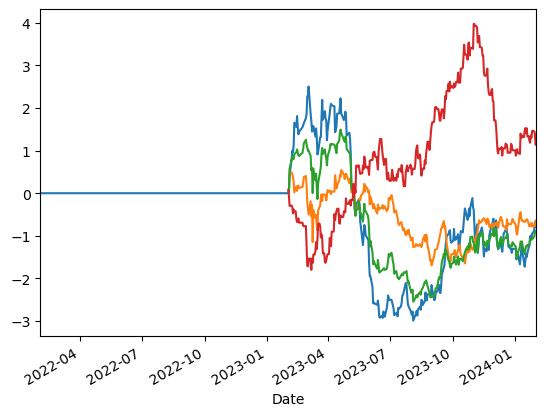

Date Range: 2022-02-01  to  2024-02-01
Sharpe for MoM, MR, and Both: -0.16592761014804164 -0.27445369852894874 -0.38062503602070646
Sharpe for Turtle: 0.3285761069036742


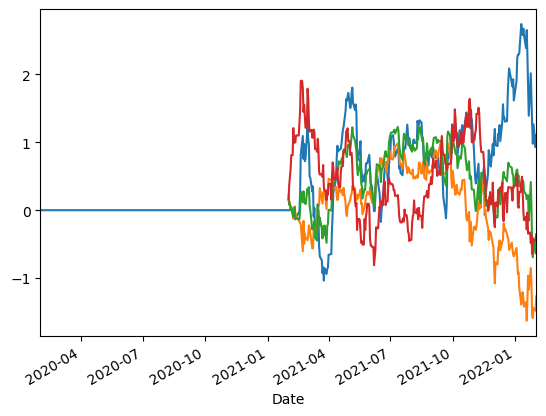

Date Range: 2020-02-01  to  2022-02-01
Sharpe for MoM, MR, and Both: 0.23638313412035558 -0.5387266529776261 -0.1629151934592598
Sharpe for Turtle: -0.10274821459237204


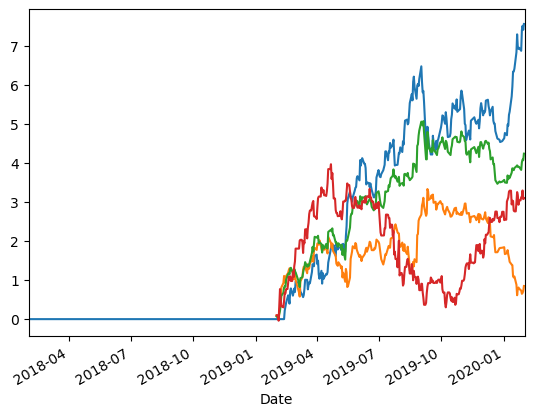

Date Range: 2018-02-01  to  2020-02-01
Sharpe for MoM, MR, and Both: 1.6205196549545389 0.36085380494181085 1.8024155150406365
Sharpe for Turtle: 0.8969533370346086


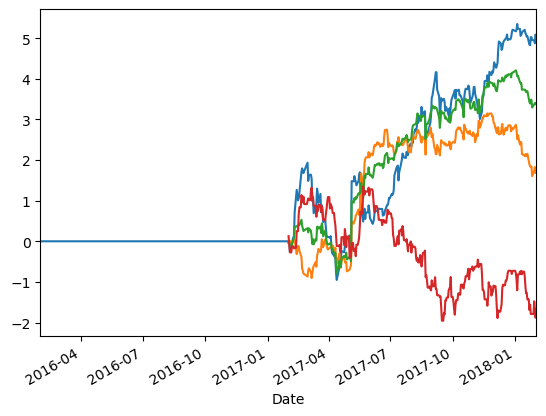

Date Range: 2016-02-01  to  2018-02-01
Sharpe for MoM, MR, and Both: 1.045263734811354 0.6989572331596803 1.3955001399258817
Sharpe for Turtle: -0.4844194043443719


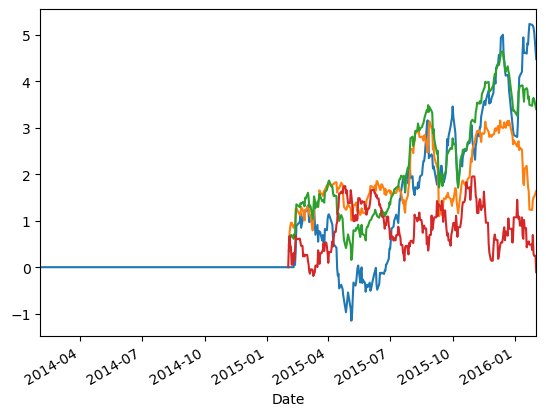

Date Range: 2014-02-01  to  2016-02-01
Sharpe for MoM, MR, and Both: 0.9641411018476219 0.7068042171225059 1.4702132897703755
Sharpe for Turtle: -0.03110253646459851


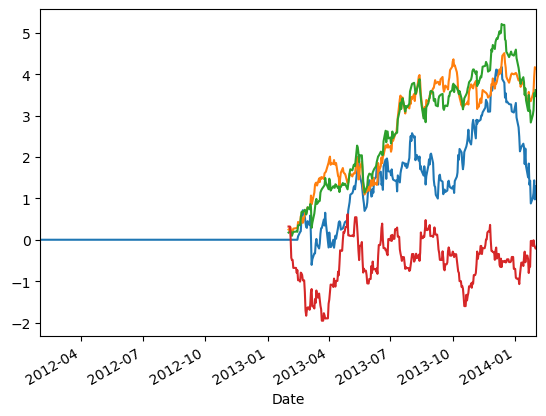

Date Range: 2012-02-01  to  2014-02-01
Sharpe for MoM, MR, and Both: 0.276853876816313 1.76252528636919 1.5368071155079817
Sharpe for Turtle: -0.061542754101218546


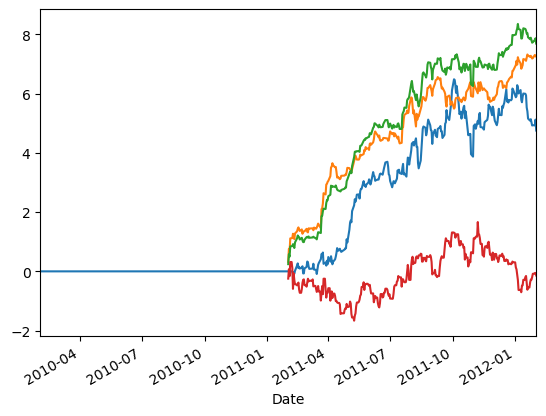

Date Range: 2010-02-01  to  2012-02-01
Sharpe for MoM, MR, and Both: 1.007704885571677 3.054943734152968 3.2404993794538854
Sharpe for Turtle: -0.04011731306652152


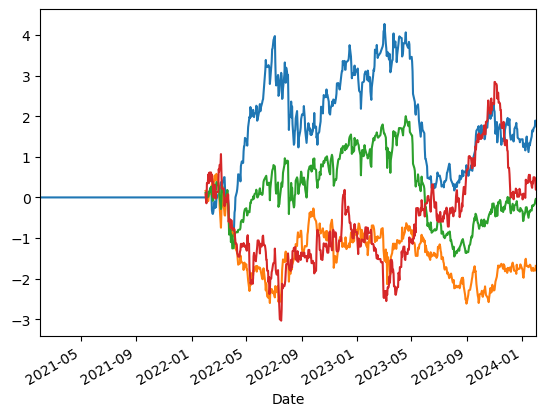

Date Range: 2021-02-01  to  2024-02-01
Sharpe for MoM, MR, and Both: 0.257440693008811 -0.3576724200149142 -0.00847823965015272
Sharpe for Turtle: 0.02770926302283176


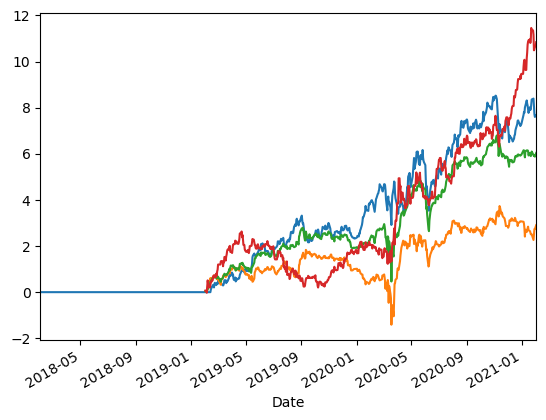

Date Range: 2018-02-01  to  2021-02-01
Sharpe for MoM, MR, and Both: 1.097309483476184 0.6207756234914947 1.2904863708429497
Sharpe for Turtle: 1.567012137471897


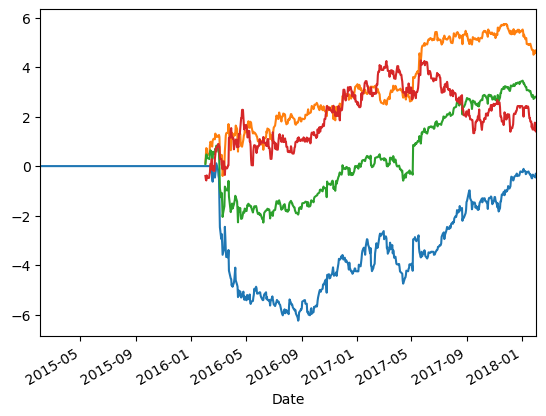

Date Range: 2015-02-01  to  2018-02-01
Sharpe for MoM, MR, and Both: -0.05099739380547182 0.9538685677228808 0.5801932662335657
Sharpe for Turtle: 0.2284741137278131


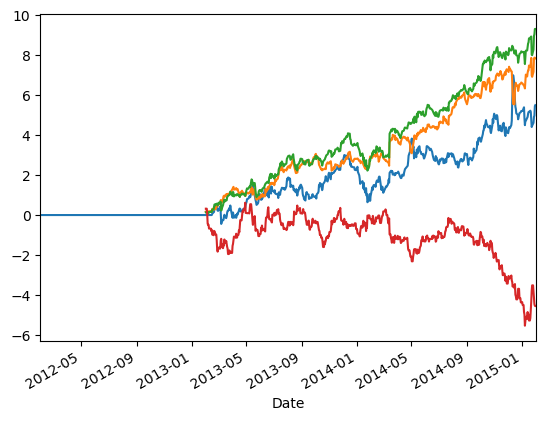

Date Range: 2012-02-01  to  2015-02-01
Sharpe for MoM, MR, and Both: 0.7854079456429195 1.6730838103682872 1.9871625070427004
Sharpe for Turtle: -0.6598593287963939


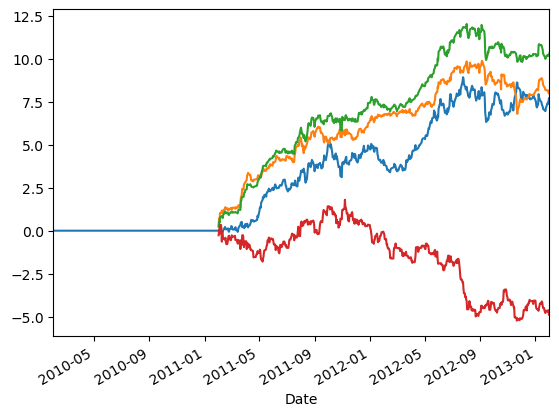

Date Range: 2010-02-01  to  2013-02-01
Sharpe for MoM, MR, and Both: 1.0826542814956919 1.7445025076399963 2.2065878047317957
Sharpe for Turtle: -0.6698695987854488


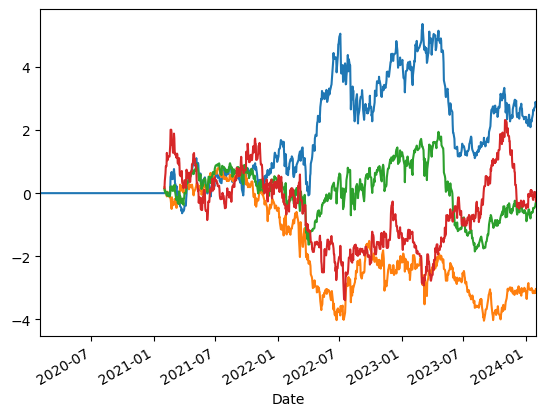

Date Range: 2020-02-01  to  2024-02-01
Sharpe for MoM, MR, and Both: 0.30040701326662245 -0.43004405350911185 -0.041798162989511924
Sharpe for Turtle: -0.02506604476588663


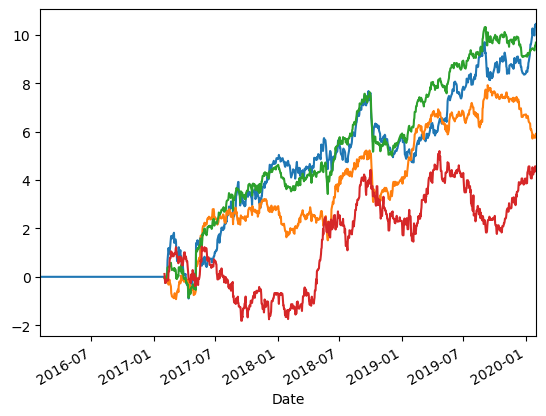

Date Range: 2016-02-01  to  2020-02-01
Sharpe for MoM, MR, and Both: 1.106284492236244 0.8347818493436645 1.3678663053893458
Sharpe for Turtle: 0.42369805854230164


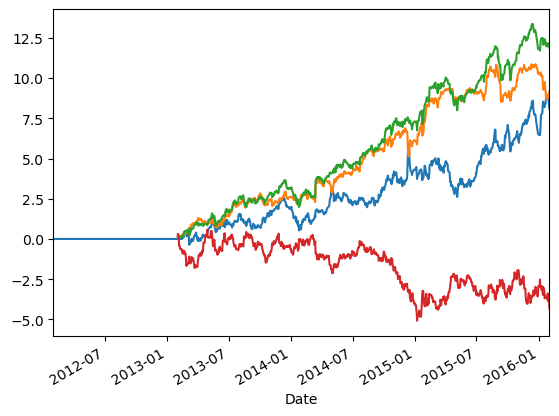

Date Range: 2012-02-01  to  2016-02-01
Sharpe for MoM, MR, and Both: 0.8678378283331463 1.303949633288542 1.69690120942359
Sharpe for Turtle: -0.41574988838006144


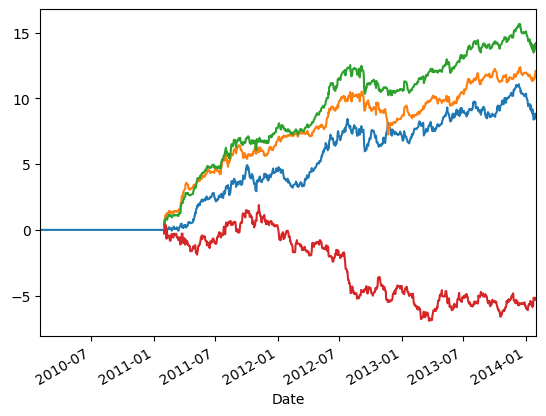

Date Range: 2010-02-01  to  2014-02-01
Sharpe for MoM, MR, and Both: 0.9305849198691456 1.7159248419219622 2.019355117093485
Sharpe for Turtle: -0.5148407990414459


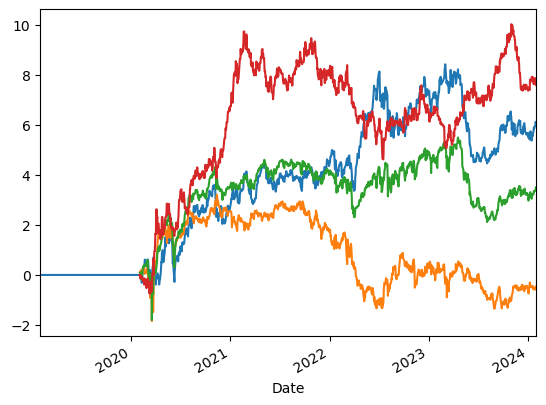

Date Range: 2019-02-01  to  2024-02-01
Sharpe for MoM, MR, and Both: 0.5169200192126413 -0.0495985027158514 0.37398149243213885
Sharpe for Turtle: 0.55030372712424


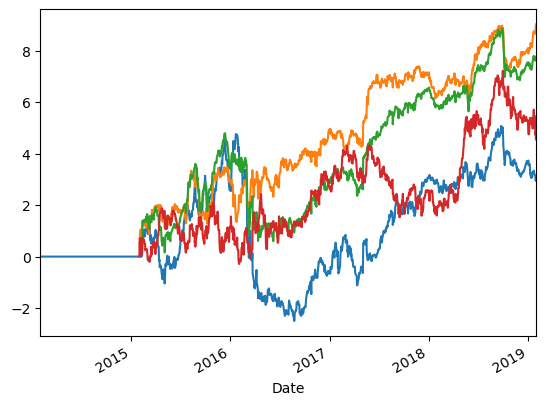

Date Range: 2014-02-01  to  2019-02-01
Sharpe for MoM, MR, and Both: 0.25129457052455856 0.9597210111939946 0.8262910033863814
Sharpe for Turtle: 0.3351663144784019


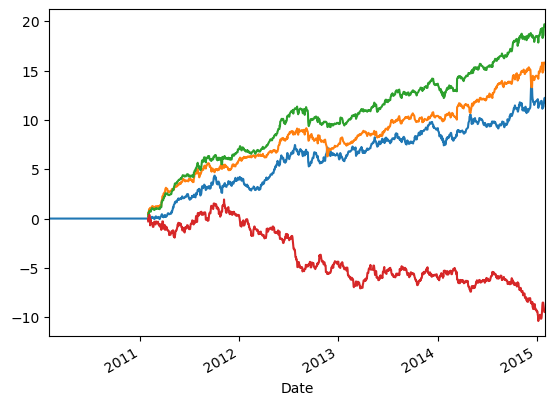

Date Range: 2010-02-01  to  2015-02-01
Sharpe for MoM, MR, and Both: 1.0427337487919366 1.6849017355406437 2.1027676293842417
Sharpe for Turtle: -0.6860379734810994


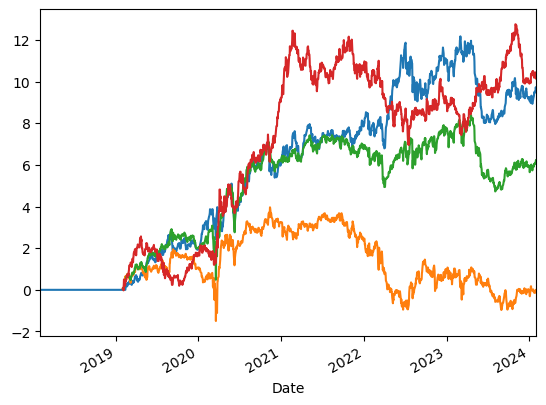

Date Range: 2018-02-01  to  2024-02-01
Sharpe for MoM, MR, and Both: 0.6872522748207643 -0.0005819228268629533 0.5304949915584293
Sharpe for Turtle: 0.5874381782136496


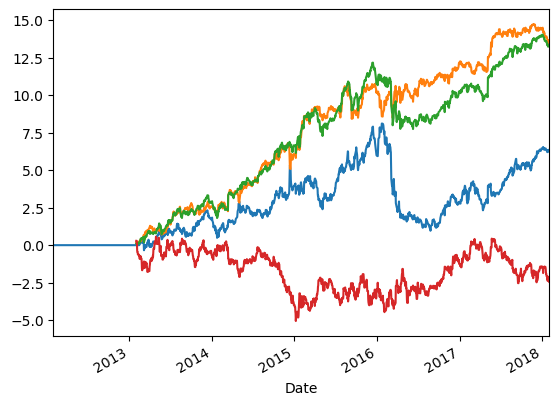

Date Range: 2012-02-01  to  2018-02-01
Sharpe for MoM, MR, and Both: 0.4484497709904248 1.1491063260099812 1.1293396415080623
Sharpe for Turtle: -0.13226224599033365


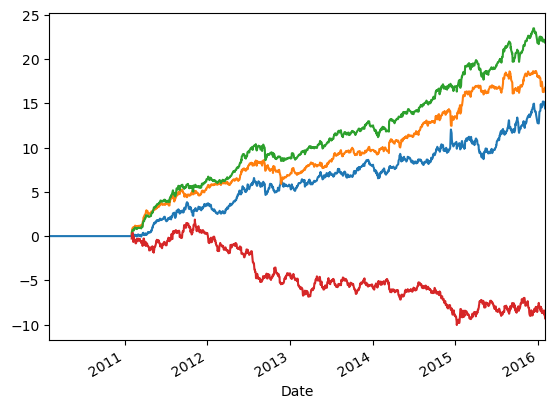

Date Range: 2010-02-01  to  2016-02-01
Sharpe for MoM, MR, and Both: 1.0302512601776825 1.4370203801194628 1.8747330811665956
Sharpe for Turtle: -0.5384995303821067


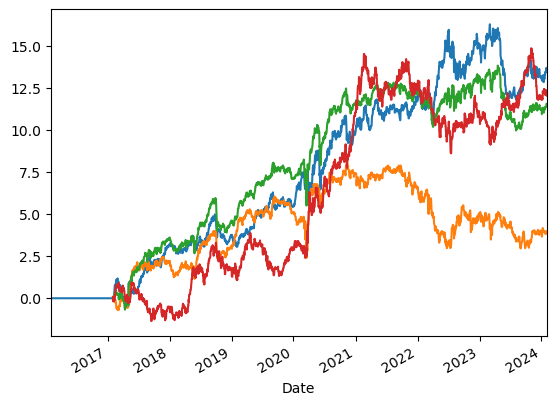

Date Range: 2016-02-01  to  2024-02-01
Sharpe for MoM, MR, and Both: 0.7234124943240438 0.24190774614794466 0.7020940942788295
Sharpe for Turtle: 0.4986489002996847


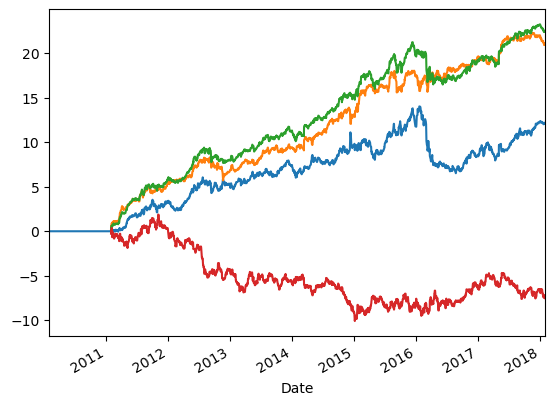

Date Range: 2010-02-01  to  2018-02-01
Sharpe for MoM, MR, and Both: 0.6465842961506275 1.2767083989548444 1.3655971874744757
Sharpe for Turtle: -0.3046884397756314


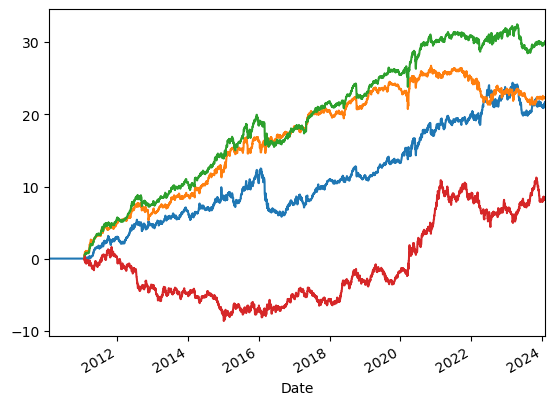

Date Range: 2010-02-01  to  2024-02-01
Sharpe for MoM, MR, and Both: 0.6595117970642579 0.7341320256279831 0.9881135073242865
Sharpe for Turtle: 0.18178976336603975


In [23]:
both_sharpe_map = {}
turtle_sharpe_map = {}
turtle_wins = 0
total = 0
turtle_win_dates = {} # Map from turtle sharpe to its date
for i, dates in enumerate(iterations):
    normalized_mom, normalized_mr, normalized_both, mom_sr, mr_sr, both_sr = benchmark_strategies(priceTable, *dates)
    both_sharpe_map[both_sr] = (dates, normalized_mom, normalized_mr, normalized_both, mom_sr, mr_sr)
    normalized_turtle, turtle_sr = turtle_returns(priceTable, dates[0], dates[1])
    turtle_sharpe_map[turtle_sr] = dates
    plt.figure()
    normalized_mom.plot() # Blue
    normalized_mr.plot() # Orange
    normalized_both.plot() # Green
    normalized_turtle.plot() # Red
    if turtle_sr > both_sr:
        turtle_wins += 1
        turtle_win_dates[turtle_sr] = dates
    total += 1
    year = dates[0][:4]
    year_in_num = int(year)
    year_num += 1
    dates[0][:4] = yea
    plt.xlim(dates[0], dates[1])
    plt.show()
    print("Date Range:", dates[0], " to ", dates[1])
    print("Sharpe for MoM, MR, and Both:", mom_sr, mr_sr, both_sr)
    print("Sharpe for Turtle:", turtle_sr)

In [24]:
myKeys = list(turtle_sharpe_map.keys())
myKeys.sort(reverse=True)
sorted_dict = {i: turtle_sharpe_map[i] for i in myKeys}

# Sharpe and dates printed in descending order
for i in myKeys:
    print("Turtle Sharpe Ratio is ", i, " for dates ", turtle_sharpe_map[i][0], " to ", turtle_sharpe_map[i][1])

Turtle Sharpe Ratio is  1.567012137471897  for dates  2018-02-01  to  2021-02-01
Turtle Sharpe Ratio is  0.8969533370346086  for dates  2018-02-01  to  2020-02-01
Turtle Sharpe Ratio is  0.5874381782136496  for dates  2018-02-01  to  2024-02-01
Turtle Sharpe Ratio is  0.55030372712424  for dates  2019-02-01  to  2024-02-01
Turtle Sharpe Ratio is  0.4986489002996847  for dates  2016-02-01  to  2024-02-01
Turtle Sharpe Ratio is  0.42369805854230164  for dates  2016-02-01  to  2020-02-01
Turtle Sharpe Ratio is  0.3351663144784019  for dates  2014-02-01  to  2019-02-01
Turtle Sharpe Ratio is  0.3285761069036742  for dates  2022-02-01  to  2024-02-01
Turtle Sharpe Ratio is  0.2284741137278131  for dates  2015-02-01  to  2018-02-01
Turtle Sharpe Ratio is  0.18178976336603975  for dates  2010-02-01  to  2024-02-01
Turtle Sharpe Ratio is  0.02770926302283176  for dates  2021-02-01  to  2024-02-01
Turtle Sharpe Ratio is  -0.02506604476588663  for dates  2020-02-01  to  2024-02-01
Turtle Sharpe 

In [25]:
print("Turtle performed better ",  turtle_wins, " out of ",  total, " times")
myKeys = list(turtle_win_dates.keys())
myKeys.sort(reverse=True)
sorted_dict = {i: turtle_win_dates[i] for i in myKeys}

#Sharpe and dates printed in descending order
for i in myKeys:
    print("Winning turtle Sharpe Ratio is ", i, " for dates ", turtle_win_dates[i][0], " to ", turtle_win_dates[i][1])

Turtle performed better  7  out of  25  times
Winning turtle Sharpe Ratio is  1.567012137471897  for dates  2018-02-01  to  2021-02-01
Winning turtle Sharpe Ratio is  0.5874381782136496  for dates  2018-02-01  to  2024-02-01
Winning turtle Sharpe Ratio is  0.55030372712424  for dates  2019-02-01  to  2024-02-01
Winning turtle Sharpe Ratio is  0.3285761069036742  for dates  2022-02-01  to  2024-02-01
Winning turtle Sharpe Ratio is  0.02770926302283176  for dates  2021-02-01  to  2024-02-01
Winning turtle Sharpe Ratio is  -0.02506604476588663  for dates  2020-02-01  to  2024-02-01
Winning turtle Sharpe Ratio is  -0.10274821459237204  for dates  2020-02-01  to  2022-02-01
